In [1]:
import pandas as pd

file_path = 'MLModel/animal_reports_population.csv'
animal_reports_df = pd.read_csv(file_path)


animal_reports_df['open_dt'] = pd.to_datetime(animal_reports_df['open_dt'], errors='coerce')
animal_reports_df['closed_dt'] = pd.to_datetime(animal_reports_df['closed_dt'], errors='coerce')


animal_reports_df['open_year_month'] = animal_reports_df['open_dt'].dt.to_period('M')
animal_reports_df['closed_year_month'] = animal_reports_df['closed_dt'].dt.to_period('M')


open_counts = animal_reports_df.groupby('open_year_month').size().rename('open_count')
closed_counts = animal_reports_df.groupby('closed_year_month').size().rename('closed_count')


monthly_counts = pd.concat([open_counts, closed_counts], axis=1).fillna(0)


monthly_counts.index = monthly_counts.index.to_timestamp()
monthly_counts.sort_index(inplace=True)


/var/folders/4n/5knzxvkj12vcp64lgw1d0l840000gn/T/ipykernel_35368/1700664273.py:4: DtypeWarning: Columns (2,14) have mixed types. Specify dtype option on import or set low_memory=False.
  animal_reports_df = pd.read_csv(file_path)


In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# SARIMA Model Fit and Forecast function
def fit_sarima(series, order, seasonal_order, steps):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast

sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 12)  # Assuming an annual seasonality

forecast_horizon = 10  # March to December

# Fit and Predict
open_forecast = fit_sarima(monthly_counts['open_count'], sarima_order, sarima_seasonal_order, forecast_horizon)
closed_forecast = fit_sarima(monthly_counts['closed_count'], sarima_order, sarima_seasonal_order, forecast_horizon)

# Combine output into a dataframe
forecast_dates = pd.date_range(start='2024-03-01', periods=forecast_horizon, freq='M')
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Open_Forecast': open_forecast,
    'Close_Forecast': closed_forecast
}).set_index('Date')

forecast_df


/var/folders/4n/5knzxvkj12vcp64lgw1d0l840000gn/T/ipykernel_35368/1563059598.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start='2024-03-01', periods=forecast_horizon, freq='M')


,Open_Forecast,Close_Forecast
Date,,
2024-03-31,233.480438,144.114003
2024-04-30,299.412913,159.316700
2024-05-31,401.704261,215.142122
2024-06-30,387.063463,216.890986
2024-07-31,421.372352,215.772517
2024-08-31,432.347949,240.714975
2024-09-30,363.538780,197.178553
2024-10-31,277.719232,196.324097
2024-11-30,221.528734,170.585487


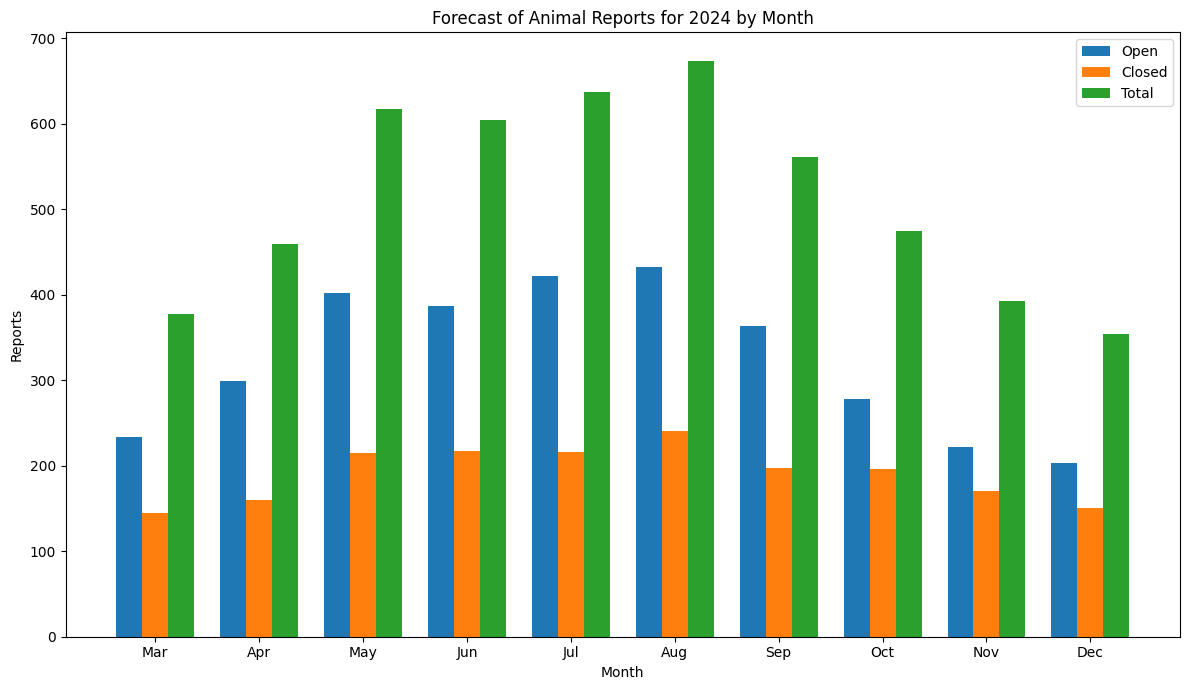

In [3]:
import matplotlib.pyplot as plt

months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
open_cases = np.array(open_forecast)
closed_cases = np.array(closed_forecast)
total_cases = open_cases + closed_cases


x = np.arange(len(months))
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.25

ax.bar(x - bar_width, open_cases, width=bar_width, label='Open')
ax.bar(x, closed_cases, width=bar_width, label='Closed')
ax.bar(x + bar_width, total_cases, width=bar_width, label='Total')

ax.set_xlabel('Month')
ax.set_ylabel('Reports')
ax.set_title('Forecast of Animal Reports for 2024 by Month')
ax.set_xticks(x)
ax.set_xticklabels(months)
ax.legend()

fig.tight_layout()

plt.show()
